## 10-8. 프로젝트: 인물 모드 문제점 찾기

만들면서 뭔가 이상한 점이 느껴지지 않으셨나요? 프로젝트를 통해 찾아봅시다.

**루브릭**

|평가문항|상세사항|
|:---|:---|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|

### Step 1. 인물모드 직접 해 보기
----
최소 3장 이상의 인물모드 사진을 만들어 봅시다. 
* 이미지 _01: 넓은 배경 사람 1명 또는 2명
* 이미지 _02: 넓인물이 아닌 조형물 또는 동물
* 이미지 _03: 넓여러 사람
* 이미지 _04: 크로마키

In [1]:
#이미지 _01: 넓은 배경 사람 1명 또는 2명
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_1 = os.getenv('HOME')+'/aiffel/human_segmentation/images/4-1.png'
img_2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/4-2.png'# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_1) 
img_bgr = cv2.imread(img_2) 
print (img_orig.shape)
print (img_bgr.shape)

(411, 363, 3)
(453, 637, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
    
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/ssac15/aiffel/human_segmentation/models
model loaded successfully!


In [19]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(411, 363, 3) (513, 453, 3) 15


In [21]:
img_resized_bg, seg_map = MODEL.run(img_bgr)
print (img_bgr.shape, img_resized.shape, seg_map.max())

(453, 637, 3) (513, 453, 3) 0


In [12]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

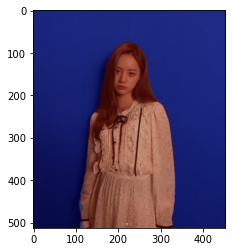

In [20]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

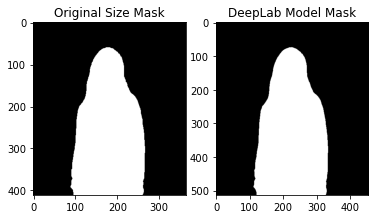

In [22]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

In [32]:
# 크로마키 합성사진 배경이미지 싸이즈 맞추기
bg_resized_image = cv2.resize(img_bgr, (363,411))

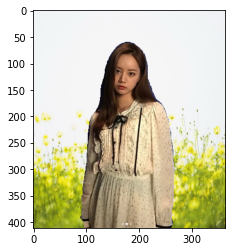

In [34]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_concat = np.where(img_mask_color==255, img_orig, bg_resized_image)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Step 2. 사진에서 문제점 찾기
---

### 이미지1-1_인물사진
**원본 사진과 비교.**
* 인물1+배경의 사진일 경우

|![r4-1](https://user-images.githubusercontent.com/76939885/106854677-13370a80-66ff-11eb-87b6-d992135010eb.jpg)|![w4-1](https://user-images.githubusercontent.com/76939885/106854686-1500ce00-66ff-11eb-98f0-29154a207d92.png)|
|:---|:---|

**이미지1-1_문제점 찾기**
* 인물 주변으로 경계가 너무 넓게 잘림.
* 경계선이 보임. (이건 내가 뭘 잘못한건가?)

![w4-1-1](https://user-images.githubusercontent.com/76939885/106855177-dddeec80-66ff-11eb-897c-da85e1059273.png)

### 이미지1-2_배경 비율이 큰 인물사진
**원본 사진과 비교**
* 인물1+배경의 사진일 경우

|![1-1 (resize)](https://user-images.githubusercontent.com/76939885/106851167-1929ed00-66f9-11eb-86b9-c07875e1a6ec.jpg)|![스크린샷, 2021-02-04 14-33-47](https://user-images.githubusercontent.com/76939885/106849539-34472d80-66f6-11eb-90a5-0e0d46c678b7.png)|
|:---|:---|

**이미지1-2_문제점 찾기**
* 인물 경계가 넓게 잘려서 합성이 부자연 스러움

![f1-1](https://user-images.githubusercontent.com/76939885/106852132-e7b22100-66fa-11eb-8e74-4620f5ffcd2f.png)


### 이미지1-3_사물을 들고있는 인물
**원본이미지와 비교**
* 인물+배경에서 사물을 들고있는 인물의 사진

|![r1-5](https://user-images.githubusercontent.com/76939885/106856317-9f4a3180-6701-11eb-8899-6f95e3b127a4.jpg)|![w1-5](https://user-images.githubusercontent.com/76939885/106856320-a07b5e80-6701-11eb-886c-5f93654c96e7.png)|
|:---|:---|

**이미지1-3_문제점 찾기**
* 인물이 들고있는 사물까지 경계를 잘 잘랐으나, 역시나 경계가 정확하지 않아 부자연 스러움 
![w1-5-1](https://user-images.githubusercontent.com/76939885/106856322-a1ac8b80-6701-11eb-8e15-933910d1e312.png)

### 이미지2_조형물
**원본 사진과 비교**
조형물의 경계가 잘 분리됨

|![r2-1](https://user-images.githubusercontent.com/76939885/106853531-32cd3380-66fd-11eb-81b2-49f0d7c06aea.jpg)|![w2-1](https://user-images.githubusercontent.com/76939885/106853533-3496f700-66fd-11eb-9bf1-cff7ca7665ee.png)|
|:---|:---|

**이미지2_문제점 찾기**

* 귀 아래 부분에 공간은 배경으로 처리가 안됨.
* 치마의 일부분의 경계가 배경으로 선택됨.
* 하지만 인물 사진에 비하여 배경의 blour처리와 조형물의 경계가 자연스러움

![w2-1-1](https://user-images.githubusercontent.com/76939885/106853930-d7e80c00-66fd-11eb-939f-9ae847e0120b.png)


### 이미지2-2_동물사진 (유리창 안에서 촬영)
**원본 사진과 비교**

|![r2-2](https://user-images.githubusercontent.com/76939885/106856885-8e4df000-6702-11eb-8a2a-94b842948605.jpg)|![w2-2](https://user-images.githubusercontent.com/76939885/106856920-9c9c0c00-6702-11eb-9a76-8b425a353d4d.png)|
|:---|:---|

**이미지2-2_문제점 찾기**
 
* 유리창 안에서 밖을 찍은 사진의 경우 전혀 경계가 안됨.
* 필터가 적용된 사진에서도 이미지 세그멘테이션이 이뤄질 수 있는 방법이 필요해 보임

|![w2-2-1](https://user-images.githubusercontent.com/76939885/106856895-90b04a00-6702-11eb-9535-75d303abba1c.png)|![w2-2-2](https://user-images.githubusercontent.com/76939885/106857033-c6edc980-6702-11eb-8ffc-ac1256bd0876.png)|
|:---|:---|

### 이미지3_단체사진
**원본 사진과 비교**


|![r3-1](https://user-images.githubusercontent.com/76939885/106852946-41671b00-66fc-11eb-934a-69b921b511bd.jpg)|![w3-1](https://user-images.githubusercontent.com/76939885/106852951-43c97500-66fc-11eb-97c0-b9b4dd03fa15.png)|
|:---|:---|

**이미지3-문제점 찾기**

* 여러 사람이 같이 있는 이미지에서는 뒤에 있는 사람의 얼굴이외의 부분에 대한 경계가 안됨.

|![w3-1-1](https://user-images.githubusercontent.com/76939885/106854186-36ad8580-66fe-11eb-9f0d-0be2cd3e70c2.png)|![w3-1-2](https://user-images.githubusercontent.com/76939885/106856575-0962d680-6702-11eb-8169-25949d6e1734.png)|
|:---|:---|

### 이미지4_크로마키 합성
 **원본 사진과 비교 & 문제점 찾기**
 
 * 경계가 부자연 스러움
 * 일반 배경 사진에 비하여 인물의 경계가 정확하게 분리됨

 ![스크린샷, 2021-02-13 18-28-03](https://user-images.githubusercontent.com/76939885/107846738-542ecd80-6e29-11eb-95dd-6d8bc8ed2fde.png)



 |![4-1](https://user-images.githubusercontent.com/76939885/107846749-6d377e80-6e29-11eb-8d83-baeea59ffe0a.png)|![4-2](https://user-images.githubusercontent.com/76939885/107846750-70326f00-6e29-11eb-8577-a4c1aa4f3760.png)|
|:---|:---|

### Step 3. 해결 방법을 제안해 보기
-----


#### 문제 1. 인물의 경계가 정확하게 분리되지 않는 문제

**해결 방안 제시:** 픽셀의 심도(depth)정보를 계산 할 수 있도록하면 경계가 좀더 정확하게 구분 될 수 있을것 같다. 
경계를 구분하는 데 있어서, 사진의 심도와 감도를 특징 벡터로 추출하여 복합적으로 적용하면, 좀더 정확한 분리(경계)가 될 수 있지 않을까 생각된다. 또는 이 부분에서 HOG(Histogram of Oriented Gradient)와 같이 edge의 방향값이 들어가면 좀더 경계분할의 정확도가 개선되지 않을까 하는 생각도 해보았다. 

#### 문제 2. 여러명의 겹쳐있는 인물 사진 Semantic Segmentation 

**해결 방안 제시:** 이미지 3번의 사진에서 중간에 겹쳐있는 인물이 일부분만 선택되는 문제가 있었는데, 구분해낸 영역에 인물이라는 label을 주었을때, 그 라벨의 특성에 대해 더 많은 정보가 있어야 의미있는 분류가 될 수 있다고 생각했다. 예를 들어 인물을 분류해 냈는데, 사람의 인체에 대한 학습이 좀더 되어 있다면, 얼굴 뿐 아니라 인체를 구성하는 기본 구조, 비율적인 정보까지 학습이 되어있다면, 위의 1번의 정보와 함꼐 결합하여 겹쳐있는 여러명의 인물사진 속에서도 개개인을 구분하여 Segmentation 해 낼 수 있을것이다. 라벨 자체에 대한 학습방법에 있어서, 데이터의 양을 늘리고, 다양한 케이스의 데이터를 적용하며, 박복적인 학습을 통해 개선해야하는 부분인 것 같다.

#### 문제 3. 필터가 적용되어 있는 사진의 Segmentation

**해결 방안 제시:** 이미지 2의 얼룩말 사진과 같이 사진을 찍을때 유리창과 같은 외부적 요인의 필터가 적용되었을 경우에도 Segmentation을 할 수 있는 방법은 없을까 생각해 보았다. 이미 스마트폰의 카메라 앱이 매우 다양하게 출시가 되어있다. 필터를 입히거나 제거하는 것과 같은 방법으로 이미지를 보정 한 후 Segmentation 진행하도록 알고리즘에 기능을 추가하는 방안을 생각해 볼 수있겠다. 

## 총평
-----
이번 노드에서 사진이미지를 만들어내는 것은 다른 과제에 비해 어렵지 않게 할 수 있었다. 그러나 문제점과 개선점을 찾아내는 일이 이전의 exploration 노드를 수행하는 것만큼 어려운 과제였다. Semantic Segmentation 분야에 대하여 이해하고, deeplab v3에 대한 이해가 없이 개선점을 도출 해 낼 수 없었기 때문에 생각보다 많은양의 학습시간이 필요했다. 

그래도 이해와 통찰을 요구하는 노드여서, 새로웠고, 학습 효과에 있어서 도약이되는 노드였다고 생각한다. 
미흡한 통찰로 인한 부족한  해결방안을 제시하였지만, 노드를 마치면서 이런 부분을 생각해 볼 수 있었다는것이 매우 의미있는 과제였던것 같다. 

